# A quick tutorial

This notebook provides a brief tutorial to modelling vehicle routing problems with PyVRP.
We will first model and solve the small capacitated VRP instance with 16 clients defined [in the OR-Tools documentation](https://developers.google.com/optimization/routing/cvrp).
This instance has an optimal solution of cost 6208.
The data are as follows:

In [1]:
# fmt: off
COORDS = [
    (456, 320),  # location 0 - the depot
    (228, 0),    # location 1
    (912, 0),    # location 2
    (0, 80),     # location 3
    (114, 80),   # location 4
    (570, 160),  # location 5
    (798, 160),  # location 6
    (342, 240),  # location 7
    (684, 240),  # location 8
    (570, 400),  # location 9
    (912, 400),  # location 10
    (114, 480),  # location 11
    (228, 480),  # location 12
    (342, 560),  # location 13
    (684, 560),  # location 14
    (0, 640),    # location 15
    (798, 640),  # location 16
]
DEMANDS = [0, 1, 1, 2, 4, 2, 4, 8, 8, 1, 2, 1, 2, 4, 4, 8, 8]
# fmt: on

We can use the `pyvrp.Model` interface to conveniently specify our vehicle routing problem using this data.
A full description of the `Model` interface is given in our [API documentation](https://pyvrp.org/api/pyvrp.html#pyvrp.Model.Model).

In [2]:
from pyvrp import Model

m = Model()
m.add_vehicle_type(capacity=15, num_available=4)
depot = m.add_depot(x=COORDS[0][0], y=COORDS[0][1])
clients = [
    m.add_client(x=COORDS[idx][0], y=COORDS[idx][1], demand=DEMANDS[idx])
    for idx in range(1, len(COORDS))
]

locations = [depot, *clients]
for frm in locations:
    for to in locations:
        distance = abs(frm.x - to.x) + abs(frm.y - to.y)  # Manhattan
        m.add_edge(frm, to, distance=distance)

Let's inspect the resulting data instance.

In [3]:
data = m.data()

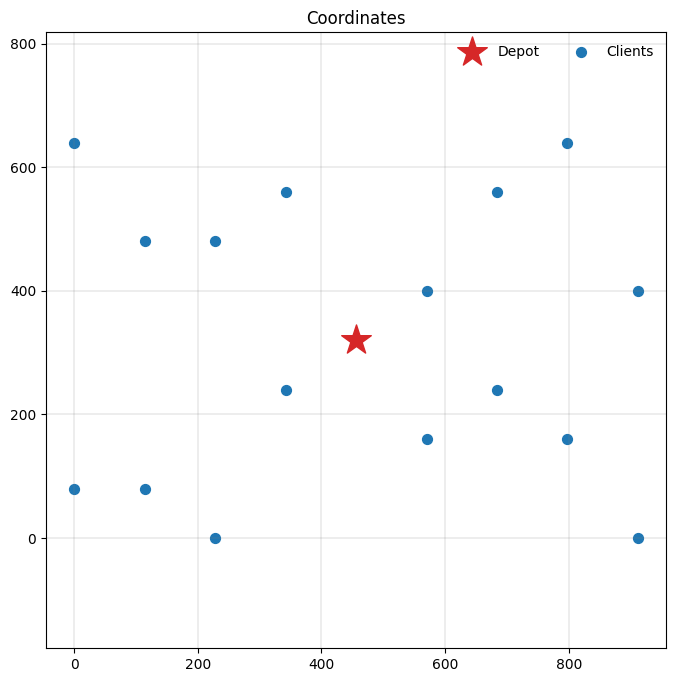

In [4]:
import matplotlib.pyplot as plt

from pyvrp.plotting import plot_coordinates

_, ax = plt.subplots(figsize=(8, 8))
plot_coordinates(data, ax=ax)

The instance looks good, so we are ready to solve it.
Let's do so with a second of runtime.

In [5]:
from pyvrp.stop import MaxRuntime

res = m.solve(stop=MaxRuntime(1))  # one second
print(res)

Solution results
    # routes: 4
   # clients: 16
   objective: 6208.00
# iterations: 304
    run-time: 1.00 seconds

Routes
------
Route #1: 9 10 16 14 
Route #2: 4 3 1 7 
Route #3: 5 2 6 8 
Route #4: 13 15 11 12 



Good! Our solution attains the same objective value as the optimal solution OR-Tools finds.
Let's inspect our solution more closely.

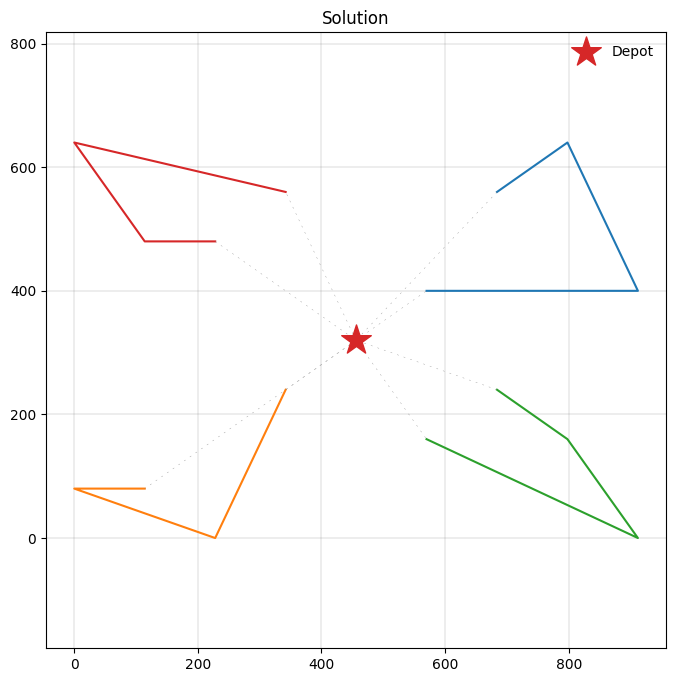

In [6]:
from pyvrp.plotting import plot_solution

_, ax = plt.subplots(figsize=(8, 8))
plot_solution(res.best, data, ax=ax)

We have just solved our first vehicle routing problem using PyVRP!
Besides the capacitated VRP, PyVRP also supports the VRP with time windows.
Let's see if we can also solve such an instance, again following the [OR-Tools documentation](https://developers.google.com/optimization/routing/vrptw).
Unlike the OR-Tools example, we do still impose capacity restrictions, and aim to minimise the total travel distance.

In [7]:
# fmt: off
DURATION_MATRIX = [
        [0, 6, 9, 8, 7, 3, 6, 2, 3, 2, 6, 6, 4, 4, 5, 9, 7],
        [6, 0, 8, 3, 2, 6, 8, 4, 8, 8, 13, 7, 5, 8, 12, 10, 14],
        [9, 8, 0, 11, 10, 6, 3, 9, 5, 8, 4, 15, 14, 13, 9, 18, 9],
        [8, 3, 11, 0, 1, 7, 10, 6, 10, 10, 14, 6, 7, 9, 14, 6, 16],
        [7, 2, 10, 1, 0, 6, 9, 4, 8, 9, 13, 4, 6, 8, 12, 8, 14],
        [3, 6, 6, 7, 6, 0, 2, 3, 2, 2, 7, 9, 7, 7, 6, 12, 8],
        [6, 8, 3, 10, 9, 2, 0, 6, 2, 5, 4, 12, 10, 10, 6, 15, 5],
        [2, 4, 9, 6, 4, 3, 6, 0, 4, 4, 8, 5, 4, 3, 7, 8, 10],
        [3, 8, 5, 10, 8, 2, 2, 4, 0, 3, 4, 9, 8, 7, 3, 13, 6],
        [2, 8, 8, 10, 9, 2, 5, 4, 3, 0, 4, 6, 5, 4, 3, 9, 5],
        [6, 13, 4, 14, 13, 7, 4, 8, 4, 4, 0, 10, 9, 8, 4, 13, 4],
        [6, 7, 15, 6, 4, 9, 12, 5, 9, 6, 10, 0, 1, 3, 7, 3, 10],
        [4, 5, 14, 7, 6, 7, 10, 4, 8, 5, 9, 1, 0, 2, 6, 4, 8],
        [4, 8, 13, 9, 8, 7, 10, 3, 7, 4, 8, 3, 2, 0, 4, 5, 6],
        [5, 12, 9, 14, 12, 6, 6, 7, 3, 3, 4, 7, 6, 4, 0, 9, 2],
        [9, 10, 18, 6, 8, 12, 15, 8, 13, 9, 13, 3, 4, 5, 9, 0, 9],
        [7, 14, 9, 16, 14, 8, 5, 10, 6, 5, 4, 10, 8, 6, 2, 9, 0],
]
TIME_WINDOWS = [
        (0, 999),  # location 0 - the depot (modified to be unrestricted)
        (7, 12),   # location 1
        (10, 15),  # location 2
        (16, 18),  # location 3
        (10, 13),  # location 4
        (0, 5),    # location 5
        (5, 10),   # location 6
        (0, 4),    # location 7
        (5, 10),   # location 8
        (0, 3),    # location 9
        (10, 16),  # location 10
        (10, 15),  # location 11
        (0, 5),    # location 12
        (5, 10),   # location 13
        (7, 8),    # location 14
        (10, 15),  # location 15
        (11, 15),  # location 16
]
# fmt: on

We now need to specify the time windows for all locations, and the duration of travelling along each edge.

In [8]:
m = Model()
m.add_vehicle_type(capacity=15, num_available=4)
depot = m.add_depot(
    x=COORDS[0][0],
    y=COORDS[0][1],
    tw_early=TIME_WINDOWS[0][0],
    tw_late=TIME_WINDOWS[0][1],
)
clients = [
    m.add_client(
        x=COORDS[idx][0],
        y=COORDS[idx][1],
        demand=DEMANDS[idx],
        tw_early=TIME_WINDOWS[idx][0],
        tw_late=TIME_WINDOWS[idx][1],
    )
    for idx in range(1, len(COORDS))
]

locations = [depot, *clients]
for frm_idx, frm in enumerate(locations):
    for to_idx, to in enumerate(locations):
        distance = abs(frm.x - to.x) + abs(frm.y - to.y)  # Manhattan
        duration = DURATION_MATRIX[frm_idx][to_idx]
        m.add_edge(frm, to, distance=distance, duration=duration)

In [9]:
res = m.solve(stop=MaxRuntime(1))  # one second
print(res)

Solution results
    # routes: 4
   # clients: 16
   objective: 6596.00
# iterations: 148
    run-time: 1.01 seconds

Routes
------
Route #1: 12 13 15 11 
Route #2: 7 1 4 3 
Route #3: 5 8 6 2 
Route #4: 9 14 16 10 



Due to the hard time windows requirements, the total travel distance has increased slightly compared to our solution for the capacitated VRP.
Let's have a look at the new solution.

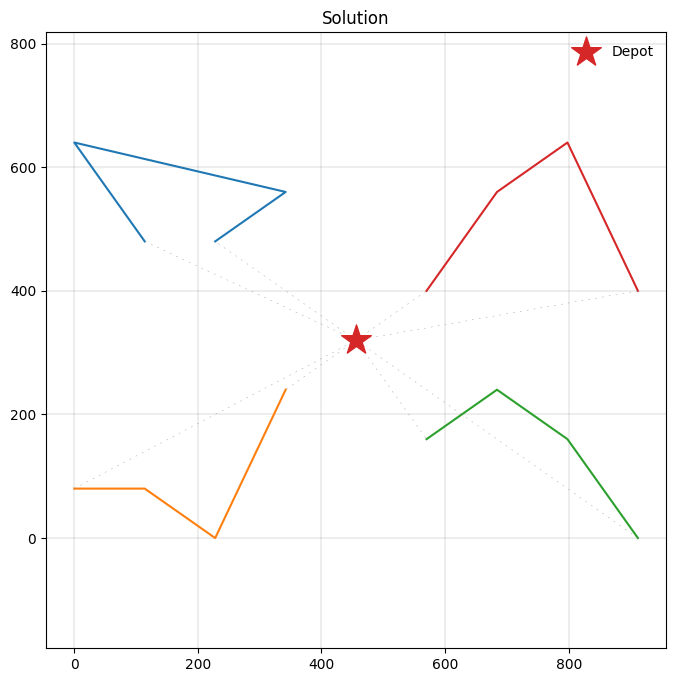

In [10]:
_, ax = plt.subplots(figsize=(8, 8))
plot_solution(res.best, data, ax=ax)

This concludes the brief tutorial: you now know how to model and solve VRP problems using PyVRP's `Model` interface.
PyVRP supports several additional VRP variants we have not covered here.
Have a look at the introduction pages, or the example notebooks to see how those can be modelled and solved. 